# MNIST + Sudoku
I'm not the saviest AI/ML guy. I don't visualize it like others do. I wish I could but I can't. That said, I can code like the wind! Instead of spending weeks coming up with an idea to really push the boundries of AI/ML, I wanted to do something a little more domestic.

My daughter and I love Sudoku, but she's getting better than me. That said, why not cheat?!

## Game plan
The idea here is to solve a Sudoku puzzle automatically from a picture. The picture can be supplied form a phone or whatever. The image will at some point need to be scaled, stretched, skewed, color-adjusted, etc. to account for real-world variance.

For now, I take an image of a Sudoku board (I made in InDesign), chop it up into 81 chunks (each a number or blank), pass the chunks through a MNIST model then through a Sudoku solver.

Enjoy.


# Train MNIST

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [2]:
# LOAD THE DATA
train = pd.read_csv('./resources/train.csv')
test = pd.read_csv('./resources/test.csv')

In [3]:
import numpy as np
from pickletools import float8
from random import shuffle, seed as random_seed, randrange
import sys
from typing import Iterable, List, Optional, Tuple, Union, cast


In [4]:
# PREPARE DATA FOR NEURAL NETWORK
train.head()
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

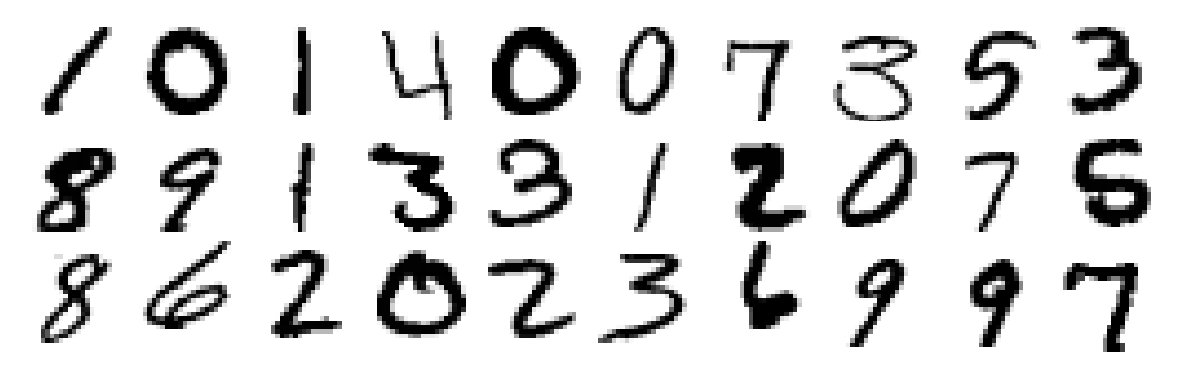

In [5]:
import matplotlib.pyplot as plt

# PREVIEW IMAGES
plt.figure(figsize=(15,4.5))

for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')

plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

## Generate more

In [6]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
# This step helps account for real-world variation
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1
)

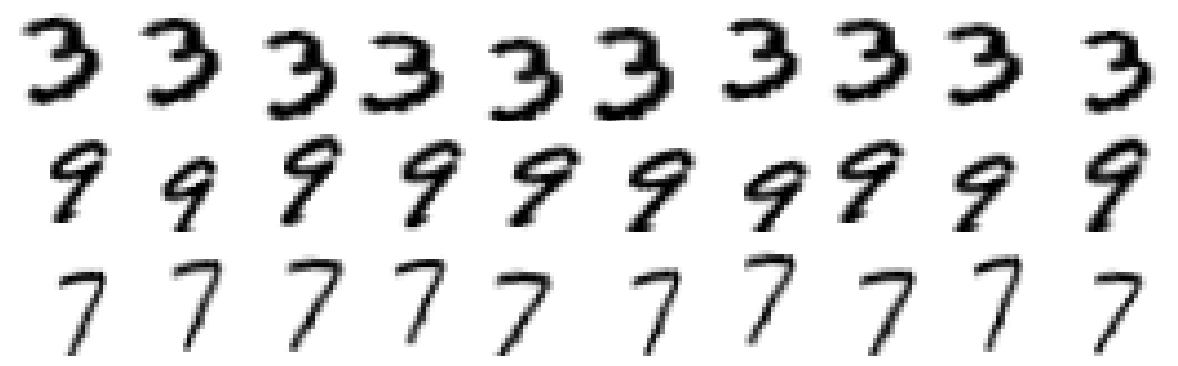

In [7]:
# PREVIEW AUGMENTED IMAGES
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))

# Sanity check
plt.figure(figsize=(15,4.5))

for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).__next__()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))

plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()


## BUILD CONVOLUTIONAL NEURAL NETWORKS

In [8]:
# Build CNN
nets = 2
model = [0] *nets

for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # Compile with Adam Optimizer + cross entropy cost
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

/Users/jedhelmers/Documents/Development/MSCS/coursera-mnist-sudoku/venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


## Train

In [9]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
epochs = 45
history = [0] * nets

# Sanity Check
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.1)
    history[j] = model[j].fit(datagen.flow(X_train2, Y_train2, batch_size=64),
                              epochs=epochs, steps_per_epoch=X_train2.shape[0] // 64,
                              validation_data=(X_val2, Y_val2), callbacks=[annealer], verbose=0)
    
    # Checking available keys in history[j].history
    print("Available keys in history[j].history:", history[j].history.keys())

    # Assuming the keys are 'accuracy' and 'val_accuracy'
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1, epochs, max(history[j].history['accuracy']), max(history[j].history['val_accuracy'])))


/Users/jedhelmers/Documents/Development/MSCS/coursera-mnist-sudoku/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-22 23:53:48.184800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, 

Available keys in history[j].history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
CNN 1: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99429


2024-03-23 01:25:26.486115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 02:52:07.350828: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 03:55:30.678747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 05:17:58.364385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 06:54:34.121728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-23 07:06:34.229349: W tensorflow/core/framework/local_rendezvous.cc:404]

Available keys in history[j].history: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])
CNN 2: Epochs=45, Train accuracy=1.00000, Validation accuracy=0.99500


In [10]:
# # DECREASE LEARNING RATE EACH EPOCH
# annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# # TRAIN NETWORKS
# history = [0] * nets
# epochs = 45
# for j in range(nets):
#     X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
#     history[j] = model[j].fit(datagen.flow(X_train2,Y_train2, batch_size=64),
#         epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
#         validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
#     print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
#         j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

In [11]:
# # SANITY CHECK
# plt.figure(figsize=(15,6))

# for i in range(40):  
#     plt.subplot(4, 10, i+1)
#     plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)
#     plt.title("predict=%d" % results[i],y=0.9)
#     plt.axis('off')

# plt.subplots_adjust(wspace=0.3, hspace=-0.1)
# plt.show()

## ENSEMBLE PREDICTIONS

In [12]:
# ENSEMBLE PREDICTIONS AND SUBMIT
results = np.zeros( (X_test.shape[0],10) )

for j in range(nets):
    results = results + model[j].predict(X_test)

results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


In [13]:
# Simplify reusable functionality
def printResult(img, result):
    plt.figure(figsize=(15,6))
    plt.imshow(img.reshape((28,28)),cmap=plt.cm.binary)
    plt.title("predict=%d %d" % (result, np.var(img)),y=0.9)


<Figure size 1500x600 with 0 Axes>

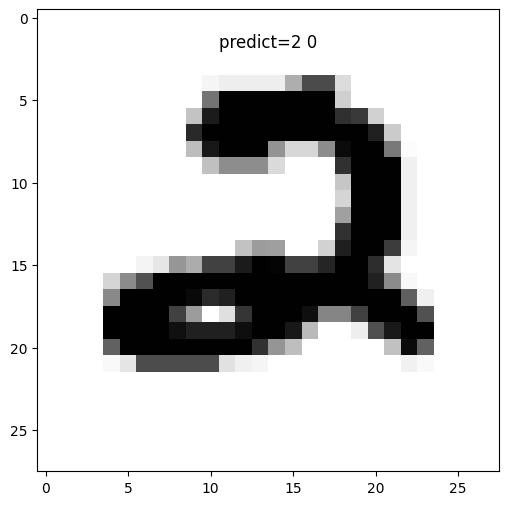

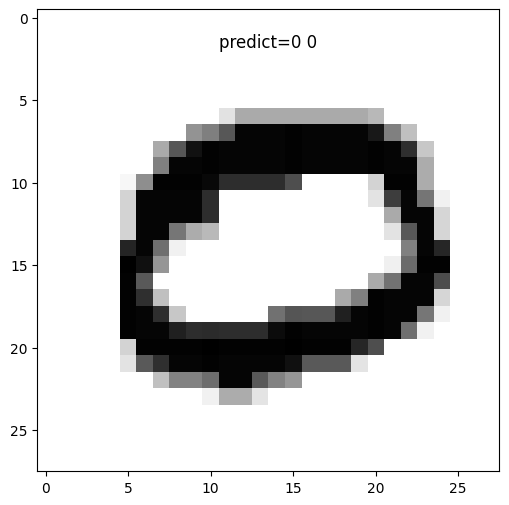

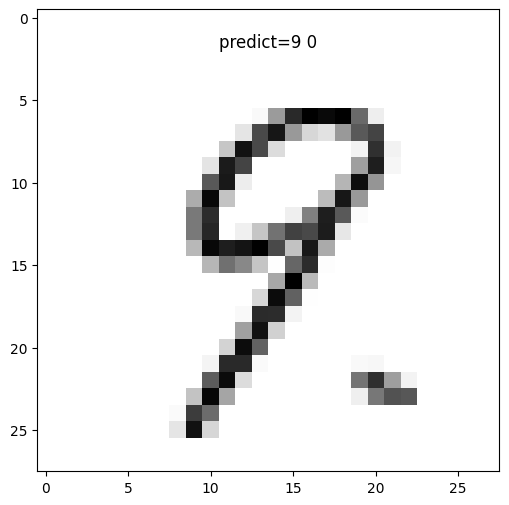

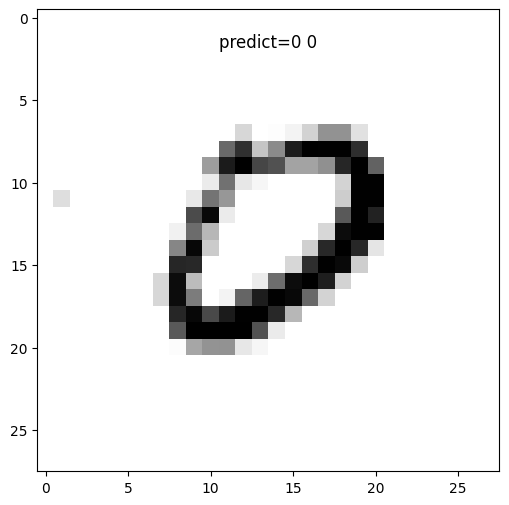

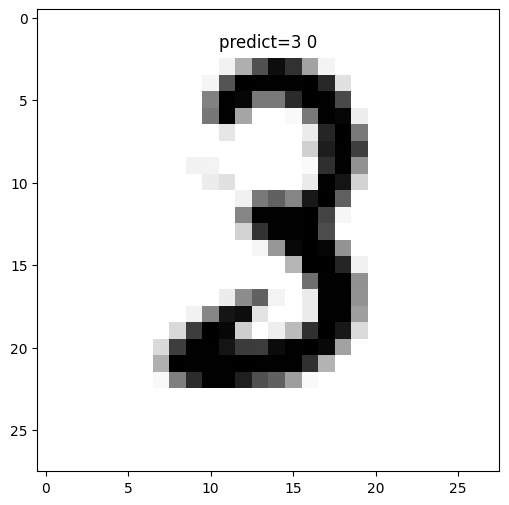

In [14]:
# PREVIEW PREDICTIONS
plt.figure(figsize=(15,6))

for i in range(5):
    printResult(X_test[i], results[i])

plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [15]:
# Save
from tensorflow.keras.models import save_model

# Save each model in the list
for j in range(nets):
    save_model(model[j], f'model_{j}.h5')  # Save each model with a unique filename


In [16]:
from tensorflow.keras.models import load_model

# Load each model back into a list
loaded_models = []
for j in range(nets):
    loaded_model = load_model(f'model_{j}.h5')
    loaded_models.append(loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


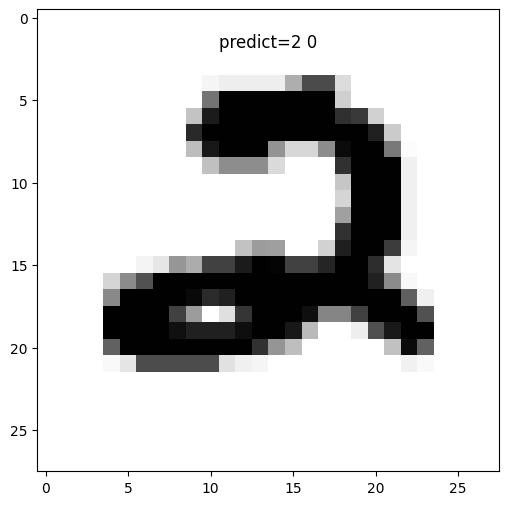

In [17]:
def predict(model, img):
    result = model.predict(input_image)
    result = np.argmax(result,axis = 1)
    result = pd.Series(result,name="Label")
    return list(result)[0]


input_image = np.expand_dims(X_test[0], axis=0)

result = predict(model[0], input_image)

# Print prediction
printResult(input_image, result)


# Get and parse puzzle

In [18]:
import cv2
import numpy as np

In [19]:
def preprocess_image(image_path, target_size=(252, 252)):
    # Read the image from the given path
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the image to the target size with nearest-neighbor interpolation
    resized_image = cv2.resize(gray_image, target_size, interpolation=cv2.INTER_NEAREST)

    # Normalize the pixel values to range [0, 1]
    normalized_image = resized_image / 255.0

    return normalized_image


In [20]:
# Get puzzle image
image_path = './resources/puzzle.png'


In [21]:
# Sanity
resized_image = preprocess_image(image_path)
print(resized_image.shape)

(252, 252)


In [22]:
import math

In [23]:

# Define dimensions of puzzle and individual digit images
puzzle_size = resized_image.shape[0]
digit_size = puzzle_size // 9  # Assuming each digit image is square

# Define threshold for blank digit sub-images
blank_threshold = 0.03  # Adjust as needed based on your images

# Iterate over puzzle to extract digit sub-images
digit_images = []

for row in range(9):
    for col in range(9):
        # Extract digit sub-image from puzzle
        digit_image = resized_image[row * digit_size:(row + 1) * digit_size,
                                    col * digit_size:(col + 1) * digit_size]
        

        digit_image = digit_image.astype(float)

        # Apply thresholding
        img = 1 - digit_image

        # Set outer perimeter pixels to 0.0
        # This chunk removes any and all
        # black lines that might be on the outer-perimeter
        # of the image from the slicing process
        img[0, :] = 0.0  # Top row
        img[-1, :] = 0.0  # Bottom row
        img[:, 0] = 0.0  # Leftmost column
        img[:, -1] = 0.0  # Rightmost column
        
        # Most sudoku puzzle have gray backgrounds in some of the squares
        # This throws everything out of wack. Thresholding removes it.
        threshold = 0.2
        img[img < threshold] = 0.0

        normalized_image_with_channel = np.expand_dims(img, axis=-1)
        digit_images.append(normalized_image_with_channel)


In [36]:
# If image variance is above a specific threshold, return True
def shouldShow(img):
    threshold = 0.0130
    return np.var(img) > threshold

In [25]:
# Sanity check
def loopThroughChunks(arr):
    for img in arr:
        normalized_image = img
        new_image = normalized_image
        new_image = np.expand_dims(new_image, axis=0)

        if shouldShow(new_image):
            plt.figure(figsize=(15,6))


            r = model[0].predict(new_image, verbose=0)
            r = np.argmax(r,axis = 1)
            r = pd.Series(r,name="Label")
            r = list(r)[0]
            print(r, np.var(new_image))

            # Print prediction
            printResult(new_image, r)

            plt.subplots_adjust(wspace=0.3, hspace=-0.1)
            plt.show()


3 0.050827039274092996


<Figure size 1500x600 with 0 Axes>

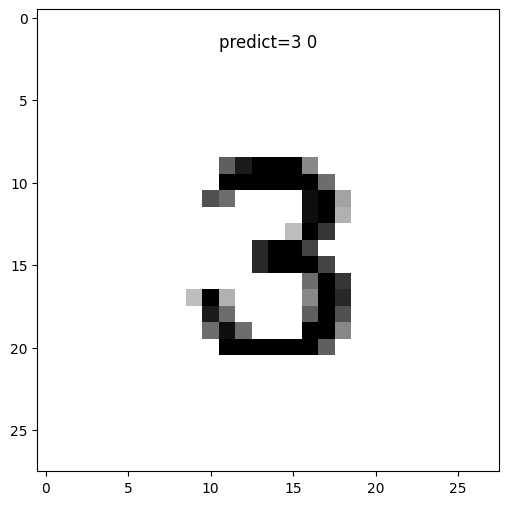

1 0.030713072644023603


<Figure size 1500x600 with 0 Axes>

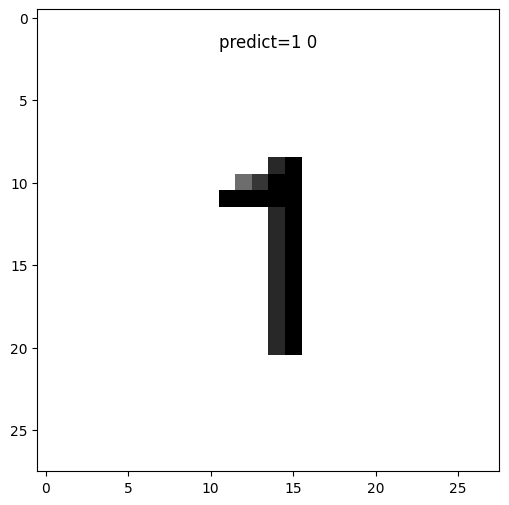

6 0.051657190862539504


<Figure size 1500x600 with 0 Axes>

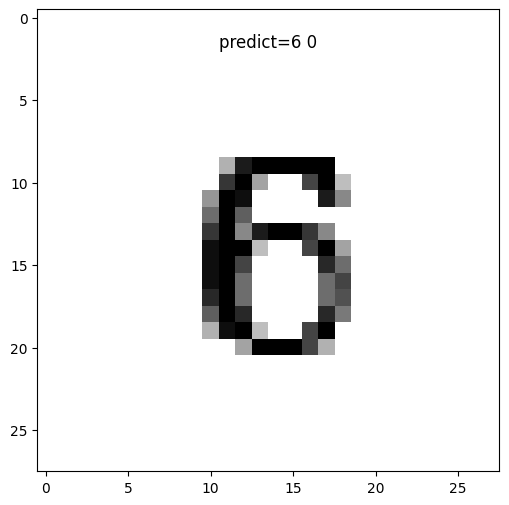

9 0.06488090331670884


<Figure size 1500x600 with 0 Axes>

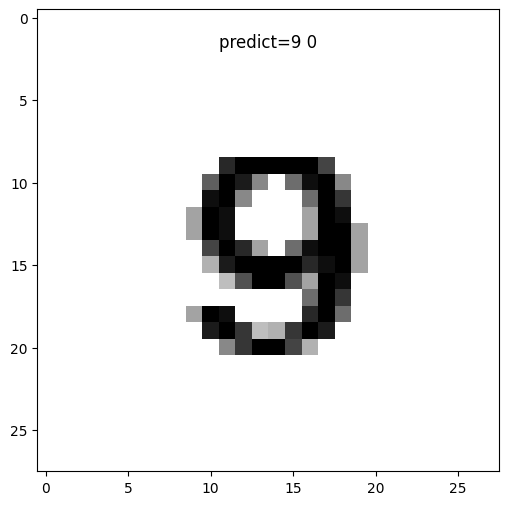

8 0.06467266195693963


<Figure size 1500x600 with 0 Axes>

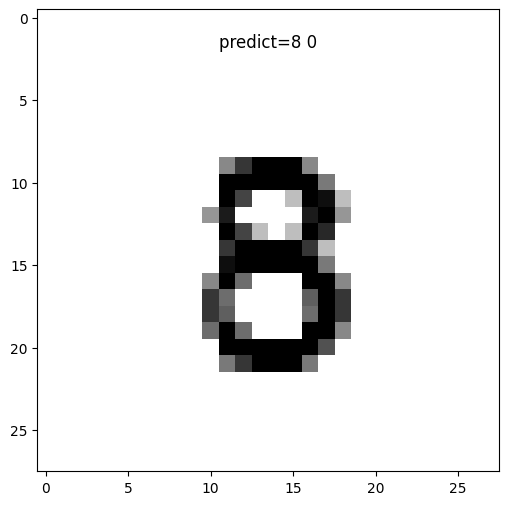

3 0.05943631704382432


<Figure size 1500x600 with 0 Axes>

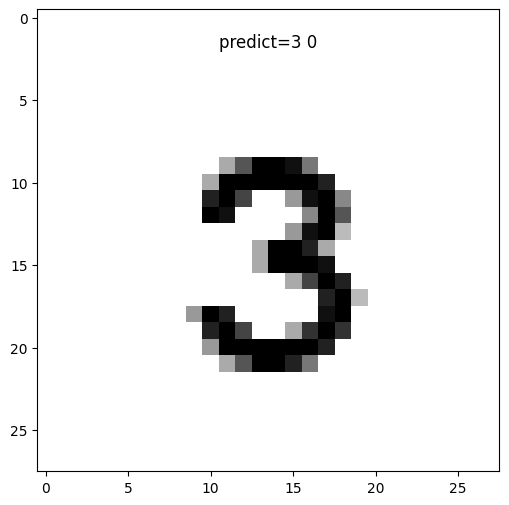

In [26]:
loopThroughChunks(digit_images[:24])

In [27]:
# Time to actually generate the board.
def generateBoard(arr):
    board = []
    cnt = 1
    new_row = []

    for img in arr:
        normalized_image = img
        new_image = normalized_image
        new_image = np.expand_dims(new_image, axis=0)

        if not shouldShow(new_image):
            new_row.append(None)
        else:
            r = model[0].predict(new_image, verbose=0)
            r = np.argmax(r,axis = 1)
            r = pd.Series(r,name="Label")
            r = list(r)[0]

            new_row.append(r)

        if cnt % 9 == 0:
            board.append(new_row.copy())
            new_row = []

        cnt += 1

    return board


In [28]:
board = generateBoard(digit_images)

# Sanity check
print(board)

[[3, None, None, None, None, None, None, None, None], [1, None, 6, None, None, None, None, 9, None], [8, None, None, None, 3, None, None, None, None], [None, None, None, None, 5, None, None, None, None], [None, None, None, None, 1, None, None, None, None], [None, None, None, 9, None, None, None, None, None], [None, None, None, None, None, None, None, None, None], [None, 5, None, None, 6, 9, None, None, None], [2, None, None, None, None, None, None, None, None]]


## SUDOKU
Once the puzzle image has been processed and chopped up into a matrix (array of arrays of ints|None), we can then move onto solving the puzzle.

## Sudoko class in Python is below

In [29]:
import numpy as np
from pickletools import float8
from random import shuffle, seed as random_seed, randrange
import sys
from typing import Iterable, List, Optional, Tuple, Union, cast

In [30]:
# Most of this Sudoku class was recycled and augmented to better suit my purposes
class UnsolvableSudoku(Exception):
    pass


class _SudokuSolver:
    def __init__(self, sudoku: 'Sudoku'):
        self.width = sudoku.width
        self.height = sudoku.height
        self.size = sudoku.size
        self.sudoku = sudoku

    def _solve(self) -> Optional['Sudoku']:
        blanks = self.__get_blanks()
        blank_count = len(blanks)
        are_blanks_filled = [False for _ in range(blank_count)]
        blank_fillers = self.__calculate_blank_cell_fillers(blanks)
        solution_board = self.__get_solution(
            Sudoku._copy_board(self.sudoku.board), blanks, blank_fillers, are_blanks_filled)
        solution_difficulty = 0
        if not solution_board:
            return None
        return Sudoku(self.width, self.height, board=solution_board, difficulty=solution_difficulty)

    def __calculate_blank_cell_fillers(self, blanks: List[Tuple[int, int]]) -> List[List[List[bool]]]:
        sudoku = self.sudoku
        valid_fillers = [[[True for _ in range(self.size)] for _ in range(
            self.size)] for _ in range(self.size)]
        for row, col in blanks:
            for i in range(self.size):
                same_row = sudoku.board[row][i]
                same_col = sudoku.board[i][col]
                if same_row and i != col:
                    valid_fillers[row][col][same_row - 1] = False
                if same_col and i != row:
                    valid_fillers[row][col][same_col - 1] = False
            grid_row, grid_col = row // sudoku.height, col // sudoku.width
            grid_row_start = grid_row * sudoku.height
            grid_col_start = grid_col * sudoku.width
            for y_offset in range(sudoku.height):
                for x_offset in range(sudoku.width):
                    if grid_row_start + y_offset == row and grid_col_start + x_offset == col:
                        continue
                    cell = sudoku.board[grid_row_start +
                                        y_offset][grid_col_start + x_offset]
                    if cell:
                        valid_fillers[row][col][cell - 1] = False
        return valid_fillers

    def __get_blanks(self) -> List[Tuple[int, int]]:
        blanks = []
        for i, row in enumerate(self.sudoku.board):
            for j, cell in enumerate(row):
                if cell == Sudoku._empty_cell_value:
                    blanks += [(i, j)]
        return blanks

    def __is_neighbor(self, blank1: Tuple[int, int], blank2: Tuple[int, int]) -> bool:
        row1, col1 = blank1
        row2, col2 = blank2
        if row1 == row2 or col1 == col2:
            return True
        grid_row1, grid_col1 = row1 // self.height, col1 // self.width
        grid_row2, grid_col2 = row2 // self.height, col2 // self.width
        return grid_row1 == grid_row2 and grid_col1 == grid_col2

    # Optimized version of above
    def __get_solution(self, board: List[List[Union[int, None]]], blanks: List[Tuple[int, int]], blank_fillers: List[List[List[bool]]], are_blanks_filled: List[bool]) -> Optional[List[List[int]]]:
        min_filler_count = None
        chosen_blank = None
        for i, blank in enumerate(blanks):
            x, y = blank
            if are_blanks_filled[i]:
                continue
            valid_filler_count = sum(blank_fillers[x][y])
            if valid_filler_count == 0:
                # Blank cannot be filled with any number, no solution
                return None
            if not min_filler_count or valid_filler_count < min_filler_count:
                min_filler_count = valid_filler_count
                chosen_blank = blank
                chosen_blank_index = i

        if not chosen_blank:
            # All blanks have been filled with valid values, return this board as the solution
            return cast(List[List[int]], board)

        row, col = chosen_blank

        # Declare chosen blank as filled
        are_blanks_filled[chosen_blank_index] = True

        # Save list of neighbors affected by the filling of current cell
        revert_list = [False for _ in range(len(blanks))]

        for number in range(self.size):
            # Only try filling this cell with numbers its neighbors aren't already filled with
            if not blank_fillers[row][col][number]:
                continue

            # Test number in this cell, number + 1 is used because number is zero-indexed
            board[row][col] = number + 1

            for i, blank in enumerate(blanks):
                blank_row, blank_col = blank
                if blank == chosen_blank:
                    continue
                if self.__is_neighbor(blank, chosen_blank) and blank_fillers[blank_row][blank_col][number]:
                    blank_fillers[blank_row][blank_col][number] = False
                    revert_list[i] = True
                else:
                    revert_list[i] = False
            solution_board = self.__get_solution(
                board, blanks, blank_fillers, are_blanks_filled)

            if solution_board:
                return solution_board

            # No solution found by having tested number in this cell
            # So we reallow neighbor cells to have this number filled in them
            for i, blank in enumerate(blanks):
                if revert_list[i]:
                    blank_row, blank_col = blank
                    blank_fillers[blank_row][blank_col][number] = True

        # If this point is reached, there is no solution with the initial board state,
        # a mistake must have been made in earlier steps

        # Declare chosen cell as empty once again
        are_blanks_filled[chosen_blank_index] = False
        board[row][col] = Sudoku._empty_cell_value

        return None


class Sudoku:
    _empty_cell_value = None

    def __init__(self, width: int = 3, height: Optional[int] = None, board: Optional[Iterable[Iterable[Union[int, None]]]] = None, difficulty: Optional[float] = None, seed: int = randrange(sys.maxsize)):
        """
        Initializes a Sudoku board

        :param width: Integer representing the width of the Sudoku grid. Defaults to 3.
        :param height: Optional integer representing the height of the Sudoku grid. If not provided, defaults to the value of `width`.
        :param board: Optional iterable for a the initial state of the Sudoku board.
        :param difficulty: Optional float representing the difficulty level of the Sudoku puzzle. If provided, sets the difficulty level based on the number of empty cells. Defaults to None.
        :param seed: Integer representing the seed for the random number generator used to generate the board. Defaults to a random seed within the system's maximum size.

        :raises AssertionError: If the width, height, or size of the board is invalid.
        """
        self.width = width
        self.height = height if height else width
        self.size = self.width * self.height
        self.__difficulty: float

        assert self.width > 0, 'Width cannot be less than 1'
        assert self.height > 0, 'Height cannot be less than 1'
        assert self.size > 1, 'Board size cannot be 1 x 1'

        if difficulty is not None:
            self.__difficulty = difficulty

        if board:
            blank_count = 0
            self.board: List[List[Union[int, None]]] = [
                [cell for cell in row] for row in board]
            for row in self.board:
                for i in range(len(row)):
                    if not row[i] in range(1, self.size + 1):
                        row[i] = Sudoku._empty_cell_value
                        blank_count += 1
            if difficulty == None:
                if self.validate():
                    self.__difficulty = blank_count / \
                        (self.size * self.size)
                else:
                    self.__difficulty = -2
        else:
            positions = list(range(self.size))
            random_seed(seed)
            shuffle(positions)
            self.board = [[(i + 1) if i == positions[j]
                           else Sudoku._empty_cell_value for i in range(self.size)] for j in range(self.size)]

    def solve(self, raising: bool = False) -> 'Sudoku':
        """
        Solves the given Sudoku board

        :param raising: Boolean for if you wish to raise an UnsolvableSodoku error when the board is invalid. Defaults to `false`.
        :raises UnsolvableSudoku:
        """
        solution = _SudokuSolver(self)._solve() if self.validate() else None
        if solution:
            return solution
        elif raising:
            raise UnsolvableSudoku('No solution found')
        else:
            solution_board = Sudoku.empty(self.width, self.height).board
            solution_difficulty = -2
            return Sudoku(board=solution_board, difficulty=solution_difficulty)

    def validate(self) -> bool:
        row_numbers = [[False for _ in range(self.size)]
                       for _ in range(self.size)]
        col_numbers = [[False for _ in range(self.size)]
                       for _ in range(self.size)]
        box_numbers = [[False for _ in range(self.size)]
                       for _ in range(self.size)]

        for row in range(self.size):
            for col in range(self.size):
                cell = self.board[row][col]
                box = (row // self.height) * self.height + (col // self.width)
                if cell == Sudoku._empty_cell_value:
                    continue
                elif isinstance(cell, int):
                    if row_numbers[row][cell - 1]:
                        return False
                    elif col_numbers[col][cell - 1]:
                        return False
                    elif box_numbers[box][cell - 1]:
                        return False
                    row_numbers[row][cell - 1] = True
                    col_numbers[col][cell - 1] = True
                    box_numbers[box][cell - 1] = True
        return True

    @ staticmethod
    def _copy_board(board: Iterable[Iterable[Union[int, None]]]) -> List[List[Union[int, None]]]:
        return [[cell for cell in row] for row in board]

    @ staticmethod
    def empty(width: int, height: int):
        size = width * height
        board = [[Sudoku._empty_cell_value] * size] * size
        return Sudoku(width, height, board, 0)

    def difficulty(self, difficulty: float) -> 'Sudoku':
        """
        Sets the difficulty of the Sudoku board by removing cells.

        This method modifies the current Sudoku instance by removing cells from the solved puzzle to achieve the desired difficulty level. The difficulty is specified as a float value between 0 and 1, where 0 represents the easiest puzzle (fully solved) and 1 represents the most difficult puzzle (almost empty).

        :param difficulty: A float value between 0 and 1 representing the desired difficulty level of the Sudoku puzzle.
        :return: A new Sudoku instance representing the puzzle with adjusted difficulty.
        :raises AssertionError: If the provided difficulty value is not within the range of 0 to 1.
        """
        assert 0 < difficulty < 1, 'Difficulty must be between 0 and 1'
        indices = list(range(self.size * self.size))
        shuffle(indices)
        problem_board = self.solve().board
        for index in indices[:int(difficulty * self.size * self.size)]:
            row_index = index // self.size
            col_index = index % self.size
            problem_board[row_index][col_index] = Sudoku._empty_cell_value
        return Sudoku(self.width, self.height, problem_board, difficulty)

    def show(self) -> None:
        """
        Prints the puzzle to the terminal
        """
        if self.__difficulty == -2:
            print('Puzzle has no solution')
        if self.__difficulty == -1:
            print('Invalid puzzle. Please solve the puzzle (puzzle.solve()), or set a difficulty (puzzle.difficulty())')
        if not self.board:
            print('No solution')
            
        return self.__format_board_ascii()

    def show_full(self) -> None:
        """
        Prints the puzzle to the terminal, with more information
        """
        print(self.__str__())

    def __format_board_ascii(self) -> str:
        table = ''
        cell_length = len(str(self.size))
        format_int = '{0:0' + str(cell_length) + 'd}'
        
        for i, row in enumerate(self.board):
            if i == 0:
                table += ('+-' + '-' * (cell_length + 1) *
                          self.width) * self.height + '+' + '\n'
            table += (('| ' + '{} ' * self.width) * self.height + '|').format(*[format_int.format(
                x) if x != Sudoku._empty_cell_value else ' ' * cell_length for x in row]) + '\n'
            if i == self.size - 1 or i % self.height == self.height - 1:
                table += ('+-' + '-' * (cell_length + 1) *
                          self.width) * self.height + '+' + '\n'
        return table
        # return self.board

    def __str__(self) -> str:
        # return f"{self.__format_board_ascii()}"
        if self.__difficulty == -2:
            difficulty_str = 'INVALID PUZZLE (GIVEN PUZZLE HAS NO SOLUTION)'
        elif self.__difficulty == -1:
            difficulty_str = 'INVALID PUZZLE'
        elif self.__difficulty == 0:
            difficulty_str = 'SOLVED'
        else:
            difficulty_str = '{:.2f}'.format(self.__difficulty)
        return '''
---------------------------
{}x{} ({}x{}) SUDOKU PUZZLE
Difficulty: {}
---------------------------
{}
        '''.format(self.size, self.size, self.width, self.height, difficulty_str, self.__format_board_ascii())


class DiagonalSudoku(Sudoku):
    def __init__(self, size: int = 3, board: Iterable[Iterable[int | None]] | None = None, difficulty: float | None = None, seed: int = randrange(sys.maxsize)):
        self.width = size
        self.height = size
        self.size = size * size
        self.__difficulty: float
        self.diagonal_left_to_right = [(i, i) for i in range(self.size)]
        self.diagonal_right_to_left = [(i, j) for i, j in enumerate(range(self.size-1,-1,-1))]

        assert self.width > 0, 'Width cannot be less than 1'
        assert self.height > 0, 'Height cannot be less than 1'
        assert self.size > 1, 'Board size cannot be 1 x 1'

        if difficulty is not None:
            self.__difficulty = difficulty

        if board:
            blank_count = 0
            self.board: List[List[Union[int, None]]] = [
                [cell for cell in row] for row in board]
            for row in self.board:
                for i in range(len(row)):
                    if row[i] not in range(1, self.size + 1):
                        row[i] = Sudoku._empty_cell_value
                        blank_count += 1
            for row, col in self.diagonal_left_to_right:
                if self.board[row][col] not in range(1, self.size+1):
                    self.board[row][col] = Sudoku._empty_cell_value
                    blank_count += 1
            for row, col in self.diagonal_right_to_left:
                if self.board[row][col] not in range(1, self.size+1):
                    self.board[row][col] = Sudoku._empty_cell_value
                    blank_count += 1
            if difficulty == None:
                if self.validate():
                    self.__difficulty = blank_count / \
                        (self.size * self.size)
                else:
                    self.__difficulty = -2
        else:
            positions = list(range(1, self.size+1))
            random_seed(seed)
            shuffle(positions)
            self.board = [[positions[j] if i == j else Sudoku._empty_cell_value for i in range(self.size)] for j in range(self.size)]

    def difficulty(self, difficulty: float) -> 'DiagonalSudoku':
        assert 0 < difficulty < 1, 'Difficulty must be between 0 and 1'
        indices = list(range(self.size * self.size))
        shuffle(indices)
        problem_board = self.solve().board
        for index in indices[:int(difficulty * self.size * self.size)]:
            row_index = index // self.size
            col_index = index % self.size
            problem_board[row_index][col_index] = Sudoku._empty_cell_value
        return DiagonalSudoku(self.width, problem_board, difficulty)

    def validate(self) -> bool:
        row_numbers = [[False for _ in range(self.size)] for _ in range(self.size)]
        col_numbers = [[False for _ in range(self.size)] for _ in range(self.size)]
        box_numbers = [[False for _ in range(self.size)] for _ in range(self.size)]
        diagonal_numbers = [[False for _ in range(self.size)] for _ in range(2)]

        for row in range(self.size):
            for col in range(self.size):
                cell = self.board[row][col]
                box = (row // self.height) * self.height + (col // self.width)
                if cell == Sudoku._empty_cell_value:
                    continue
                elif isinstance(cell, int):
                    if row_numbers[row][cell - 1] or col_numbers[col][cell - 1] or box_numbers[box][cell - 1]:
                        return False
                    row_numbers[row][cell - 1] = True
                    col_numbers[col][cell - 1] = True
                    box_numbers[box][cell - 1] = True
        for i in self.diagonal_left_to_right:
            cell = self.board[i[0]][i[1]]
            if cell == Sudoku._empty_cell_value:
                continue
            elif isinstance(cell, int):
                if diagonal_numbers[0][cell - 1]:
                    return False
                diagonal_numbers[0][cell - 1] = True
        for i in self.diagonal_right_to_left:
            cell = self.board[i[0]][i[1]]
            if cell == Sudoku._empty_cell_value:
                continue
            elif isinstance(cell, int):
                if diagonal_numbers[1][cell - 1]:
                    return False
                diagonal_numbers[1][cell - 1] = True
        return True

    def solve(self, raising: bool = False) -> 'DiagonalSudoku':
        solution = _DiagonalSudokuSolver(self)._solve() if self.validate() else None
        if solution:
            return solution
        elif raising:
            raise UnsolvableSudoku('No solution found')
        else:
            solution_board = DiagonalSudoku.empty(self.width, self.height).board
            solution_difficulty = -2
            return DiagonalSudoku(board=solution_board, difficulty=solution_difficulty)
    
    def show(self) -> None:
        if self.__difficulty == -2:
            print('Puzzle has no solution')
        if self.__difficulty == -1:
            print('Invalid puzzle. Please solve the puzzle (puzzle.solve()), or set a difficulty (puzzle.difficulty())')
        if not self.board:
            print('No solution')
        print(self.__format_board_ascii())

    def show_full(self) -> None:
        # print(self.__str__())
        pass

    def __format_board_ascii(self) -> str:
        table = ''
        cell_length = len(str(self.size))
        row_square = []
        format_int = '{0:0' + str(cell_length) + 'd}'

        for i, row in enumerate(self.board):
            if i == 0:
                table += ('+-' + '-' * (cell_length + 1) * self.width) * self.height + '+' + '\n'
            
            for x in range(len(row)):
                if x != Sudoku._empty_cell_value:
                    if i == x:
                        row_square.append("\033[1m\033[4m{}\033[0m".format(format_int.format(row[x])))
                    elif self.diagonal_right_to_left[i][1] == x:
                        row_square.append("\033[1m\033[4m{}\033[0m".format(format_int.format(row[x])))
                    else:
                        row_square.append(format_int.format(row[x]))
                else:
                    row_square.append(' ' * cell_length)
            table += (('| ' + '{} ' * self.width) * self.height + '|').format(*row_square)  + '\n'
            row_square = []

            if i == self.size - 1 or i % self.height == self.height - 1:
                table += ('+-' + '-' * (cell_length + 1) * self.width) * self.height + '+' + '\n'
        return table

    def __str__(self) -> str:
        # return f"{self.__format_board_ascii()}"
        if self.__difficulty == -2:
            difficulty_str = 'INVALID PUZZLE (GIVEN PUZZLE HAS NO SOLUTION)'
        elif self.__difficulty == -1:
            difficulty_str = 'INVALID PUZZLE'
        elif self.__difficulty == 0:
            difficulty_str = 'SOLVED'
        else:
            difficulty_str = '{:.2f}'.format(self.__difficulty)
        return '''
------------------------------------
{}x{} ({}x{}) DIAGONAL SUDOKU PUZZLE
Difficulty: {}
------------------------------------
{}
        '''.format(self.size, self.size, self.width, self.height, difficulty_str, self.__format_board_ascii())


class _DiagonalSudokuSolver(_SudokuSolver):
    def __init__(self, sudoku: DiagonalSudoku):
        super().__init__(sudoku)
        self.diagonal_left_to_right = [(i, i) for i in range(self.size)]
        self.diagonal_right_to_left = [(i, j) for i, j in enumerate(range(self.size-1,-1,-1))]

    def _solve(self) -> Optional['DiagonalSudoku']:
        blanks = self.__get_blanks()
        blank_count = len(blanks)
        are_blanks_filled = [False for _ in range(blank_count)]
        blank_fillers = self.__calculate_blank_cell_fillers(blanks)
        solution_board = self.__get_solution(
            DiagonalSudoku._copy_board(self.sudoku.board), blanks, blank_fillers, are_blanks_filled)
        solution_difficulty = 0
        if not solution_board:
            return None
        return DiagonalSudoku(self.width, board=solution_board, difficulty=solution_difficulty)

    def __get_blanks(self) -> List[Tuple[int, int]]:
        blanks = []
        for i, row in enumerate(self.sudoku.board):
            for j, cell in enumerate(row):
                if cell == Sudoku._empty_cell_value:
                    blanks += [(i, j)]
        return blanks

    def __is_neighbor(self, blank1: Tuple[int, int], blank2: Tuple[int, int]) -> bool:
        """
        The function checks whether the cells are neighbors.
        Checks whether they are in one row, in one column,
        in one square whose dimensions are `self.width` and in the same diagonal.
        """
        row1, col1 = blank1
        row2, col2 = blank2
        if row1 == row2 or col1 == col2:
            return True
        grid_row1, grid_col1 = row1 // self.height, col1 // self.width
        grid_row2, grid_col2 = row2 // self.height, col2 // self.width
        if grid_row1 == grid_row2 and grid_col1 == grid_col2:
            return True
        if blank1 in self.diagonal_left_to_right and blank2 in self.diagonal_left_to_right:
            return True
        return blank1 in self.diagonal_right_to_left and blank2 in self.diagonal_right_to_left

    def __calculate_blank_cell_fillers(self, blanks: List[Tuple[int, int]]) -> List[List[List[bool]]]:
        sudoku = self.sudoku
        valid_fillers = [[[True for _ in range(self.size)] for _ in range(
            self.size)] for _ in range(self.size)]
        for row, col in blanks:
            for i in range(self.size):
                same_row = sudoku.board[row][i]
                same_col = sudoku.board[i][col]
                if same_row and i != col:
                    valid_fillers[row][col][same_row - 1] = False
                if same_col and i != row:
                    valid_fillers[row][col][same_col - 1] = False
            
            grid_row, grid_col = row // sudoku.height, col // sudoku.width
            grid_row_start = grid_row * sudoku.height
            grid_col_start = grid_col * sudoku.width
            for y_offset in range(sudoku.height):
                for x_offset in range(sudoku.width):
                    if grid_row_start + y_offset == row and grid_col_start + x_offset == col:
                        continue
                    cell = sudoku.board[grid_row_start + y_offset][grid_col_start + x_offset]
                    if cell:
                        valid_fillers[row][col][cell - 1] = False
            
            if (row, col) in self.diagonal_left_to_right:
                for i in self.diagonal_left_to_right:
                    same_diagonal = sudoku.board[row][col]
                    if i == (row,col) or not same_diagonal:
                        continue
                    valid_fillers[row][col][same_diagonal - 1] = False
            elif (row, col) in self.diagonal_right_to_left:
                for i in self.diagonal_right_to_left:
                    same_diagonal = sudoku.board[i[0]][i[1]]
                    if i == (row,col) or not same_diagonal:
                        continue
                    valid_fillers[row][col][same_diagonal - 1] = False
        return valid_fillers
    
    def __get_solution(self, board: List[List[Union[int, None]]], blanks: List[Tuple[int, int]], blank_fillers: List[List[List[bool]]], are_blanks_filled: List[bool]) -> Optional[List[List[int]]]:
        min_filler_count = None
        chosen_blank = None
        for i, blank in enumerate(blanks):
            x, y = blank
            if are_blanks_filled[i]:
                continue
            valid_filler_count = sum(blank_fillers[x][y])
            if valid_filler_count == 0:
                return None
            if not min_filler_count or valid_filler_count < min_filler_count:
                min_filler_count = valid_filler_count
                chosen_blank = blank
                chosen_blank_index = i
        
        if not chosen_blank:
            return cast(List[List[int]], board)
        
        row, col = chosen_blank
        are_blanks_filled[chosen_blank_index] = True
        revert_list = [False for _ in range(len(blanks))]
        for number in range(self.size):
            if not blank_fillers[row][col][number]:
                continue
            board[row][col] = number + 1
            for i, blank in enumerate(blanks):
                blank_row, blank_col = blank
                if blank == chosen_blank:
                    continue
                if self.__is_neighbor(blank, chosen_blank) and blank_fillers[blank_row][blank_col][number]:
                    blank_fillers[blank_row][blank_col][number] = False
                    revert_list[i] = True
                else:
                    revert_list[i] = False
            solution_board = self.__get_solution(
                board, blanks, blank_fillers, are_blanks_filled)
            if solution_board:
                return solution_board
            for i, blank in enumerate(blanks):
                if revert_list[i]:
                    blank_row, blank_col = blank
                    blank_fillers[blank_row][blank_col][number] = True
        are_blanks_filled[chosen_blank_index] = False
        board[row][col] = Sudoku._empty_cell_value
        return None



## Example sudoku puzzle
The Sudoku class can generate, show and solver puzzles

In [31]:
puzzle = Sudoku(3).difficulty(0.5)
print(puzzle.show())
print(puzzle.solve().show())

+-------+-------+-------+
|       |   8 2 | 1   7 |
| 4   6 |   5   | 2 3   |
| 2     | 1 3   |     9 |
+-------+-------+-------+
| 7 4 5 | 9     | 6 8 2 |
| 6 8 1 |   4   |   9   |
|   3 2 | 8     |     1 |
+-------+-------+-------+
| 3     | 4 9 1 | 8     |
|     9 |     7 |   1   |
| 1     |     8 |   7 6 |
+-------+-------+-------+

+-------+-------+-------+
| 5 9 3 | 6 8 2 | 1 4 7 |
| 4 1 6 | 7 5 9 | 2 3 8 |
| 2 7 8 | 1 3 4 | 5 6 9 |
+-------+-------+-------+
| 7 4 5 | 9 1 3 | 6 8 2 |
| 6 8 1 | 2 4 5 | 7 9 3 |
| 9 3 2 | 8 7 6 | 4 5 1 |
+-------+-------+-------+
| 3 6 7 | 4 9 1 | 8 2 5 |
| 8 2 9 | 5 6 7 | 3 1 4 |
| 1 5 4 | 3 2 8 | 9 7 6 |
+-------+-------+-------+



In [32]:
new_puzzle = Sudoku(3, board=board)

In [33]:
print(new_puzzle.show())

+-------+-------+-------+
| 3     |       |       |
| 1   6 |       |   9   |
| 8     |   3   |       |
+-------+-------+-------+
|       |   5   |       |
|       |   1   |       |
|       | 9     |       |
+-------+-------+-------+
|       |       |       |
|   5   |   6 9 |       |
| 2     |       |       |
+-------+-------+-------+



## MNIST + Sudoku Field Test

In [34]:
print(new_puzzle.solve().show())

+-------+-------+-------+
| 3 4 5 | 6 9 8 | 1 7 2 |
| 1 2 6 | 5 4 7 | 3 9 8 |
| 8 7 9 | 1 3 2 | 5 4 6 |
+-------+-------+-------+
| 6 9 4 | 7 5 3 | 2 8 1 |
| 7 3 2 | 8 1 4 | 6 5 9 |
| 5 1 8 | 9 2 6 | 4 3 7 |
+-------+-------+-------+
| 9 6 1 | 3 8 5 | 7 2 4 |
| 4 5 7 | 2 6 9 | 8 1 3 |
| 2 8 3 | 4 7 1 | 9 6 5 |
+-------+-------+-------+



# BAM! Solved it

Future iterations will account for real-world situations (ie. taking images from a phone, sckewing, scaling, adjusting, etc.)

In [67]:
image_path = './resources/cropped_puzzle.png'

class SudokuCNN:
    def __init__(self, model, img_path: str) -> None:
        self.model = model
        
        # Iterate over puzzle to extract digit sub-images
        self.digit_images = []
        self.chunkImage(img_path)   

    def preprocess_image(self, image_path, target_size=(252, 252)):
        # Read the image from the given path
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the image to the target size with nearest-neighbor interpolation
        resized_image = cv2.resize(gray_image, target_size, interpolation=cv2.INTER_NEAREST)

        # Normalize the pixel values to range [0, 1]
        normalized_image = resized_image / 255.0

        return normalized_image


    def chunkImage(self, image_path):
        # Sanity
        resized_image = self.preprocess_image(image_path)
        print(resized_image.shape)

        # Define dimensions of puzzle and individual digit images
        puzzle_size = resized_image.shape[0]
        digit_size = puzzle_size // 9  # Assuming each digit image is square

        # Define threshold for blank digit sub-images
        blank_threshold = 0.03  # Adjust as needed based on your images


        for row in range(9):
            for col in range(9):
                # Extract digit sub-image from puzzle
                digit_image = resized_image[row * digit_size:(row + 1) * digit_size,
                                            col * digit_size:(col + 1) * digit_size]
                

                digit_image = digit_image.astype(float)

                # Apply thresholding
                img = 1 - digit_image

                # Set outer perimeter pixels to 0.0
                # This chunk removes any and all
                # black lines that might be on the outer-perimeter
                # of the image from the slicing process
                # Chop border by n
                chop_border_by_n = 5
                border_shade = 0.0

                img[:chop_border_by_n, :] = border_shade  # Top row
                img[-chop_border_by_n - 1:, :] = border_shade  # Bottom row
                img[:, :chop_border_by_n] = border_shade  # Leftmost column
                img[:, -chop_border_by_n - 1:] = border_shade  # Rightmost column
                
                # Most sudoku puzzle have gray backgrounds in some of the squares
                # This throws everything out of wack. Thresholding removes it.
                threshold = 0.2
                img[img < threshold] = 0.0

                # Zoom factor
                zoom_factor = 1.5

                # Calculate the center coordinates and dimensions of the ROI
                center_x = img.shape[1] // 2
                center_y = img.shape[0] // 2
                roi_width = int(img.shape[1] / zoom_factor)
                roi_height = int(img.shape[0] / zoom_factor)

                # Define the ROI
                roi = img[center_y - roi_height // 2:center_y + roi_height // 2, 
                            center_x - roi_width // 2:center_x + roi_width // 2]

                # Resize the ROI to fit the original img size
                zoomed_img = cv2.resize(roi, (img.shape[1], img.shape[0]))

                normalized_image_with_channel = np.expand_dims(zoomed_img, axis=-1)
                self.digit_images.append(normalized_image_with_channel)

    # If image variance is above a specific threshold, return True
    def shouldShow(self, img):
        threshold = 0.0130
        return np.var(img) > threshold
    
    # Simplify reusable functionality
    def printResult(self, img, result):
        plt.figure(figsize=(15,6))
        plt.imshow(img.reshape((28,28)),cmap=plt.cm.binary)
        plt.title("predict=%d %d" % (result, np.var(img)),y=0.9)

    # If image variance is above a specific threshold, return True
    def shouldShow(self, img):
        threshold = 0.0130
        return np.var(img) > threshold

    # Sanity check
    def loopThroughChunks(self, n_chunks):
        for img in self.digit_images[:n_chunks]:
            normalized_image = img
            new_image = normalized_image
            new_image = np.expand_dims(new_image, axis=0)

            if self.shouldShow(new_image):
                plt.figure(figsize=(15,6))


                r = self.model.predict(new_image, verbose=0)
                r = np.argmax(r,axis = 1)
                r = pd.Series(r,name="Label")
                r = list(r)[0]
                print(r, np.var(new_image))

                # Print prediction
                self.printResult(new_image, r)

                plt.subplots_adjust(wspace=0.3, hspace=-0.1)
                plt.show()

    # Time to actually generate the board.
    def generateBoard(self):
        board = []
        cnt = 1
        new_row = []

        for img in self.digit_images:
            normalized_image = img
            new_image = normalized_image
            new_image = np.expand_dims(new_image, axis=0)

            if not self.shouldShow(new_image):
                new_row.append(None)
            else:
                r = self.model.predict(new_image, verbose=0)
                r = np.argmax(r,axis = 1)
                r = pd.Series(r,name="Label")
                r = list(r)[0]

                new_row.append(r)

            if cnt % 9 == 0:
                board.append(new_row.copy())
                new_row = []

            cnt += 1

        return board


In [68]:
sudokuCnn = SudokuCNN(model[0], image_path)

(252, 252)


7 0.07594910663034557


<Figure size 1500x600 with 0 Axes>

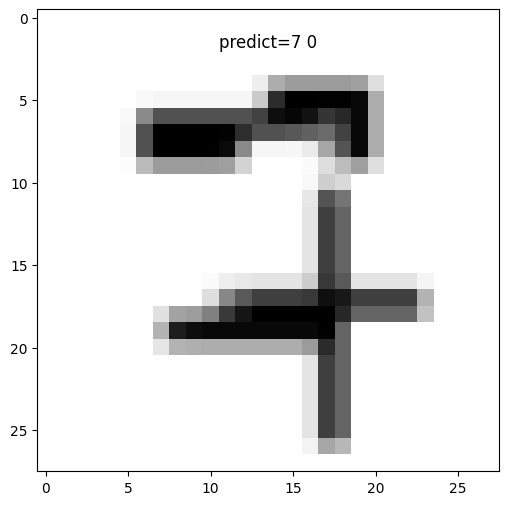

2 0.0875033317775759


<Figure size 1500x600 with 0 Axes>

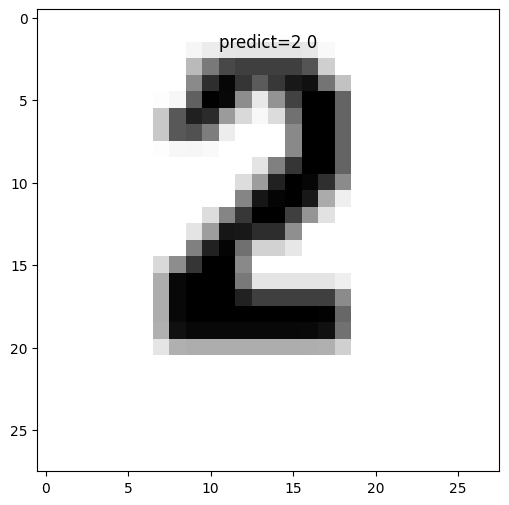

In [70]:
sudokuCnn.loopThroughChunks(5)

In [71]:
sudokuCnn.generateBoard()

[[7, None, 2, None, None, 9, 4, None, None],
 [1, 9, None, None, 5, 2, None, None, None],
 [8, None, None, None, None, None, None, None, 1],
 [None, 7, None, None, 8, 5, None, None, None],
 [None, 6, 8, None, None, None, None, 4, None],
 [None, None, None, 9, 6, None, None, 8, None],
 [6, None, 7, None, None, None, None, None, 3],
 [None, None, None, 5, 2, 6, None, 1, 7],
 [None, None, 5, 7, None, None, 6, None, None]]

In [72]:
new_puzzle = Sudoku(3, board=sudokuCnn.generateBoard())
print(new_puzzle.show())
print(new_puzzle.solve().show())

+-------+-------+-------+
| 7   2 |     9 | 4     |
| 1 9   |   5 2 |       |
| 8     |       |     1 |
+-------+-------+-------+
|   7   |   8 5 |       |
|   6 8 |       |   4   |
|       | 9 6   |   8   |
+-------+-------+-------+
| 6   7 |       |     3 |
|       | 5 2 6 |   1 7 |
|     5 | 7     | 6     |
+-------+-------+-------+

+-------+-------+-------+
| 7 3 2 | 8 1 9 | 4 6 5 |
| 1 9 4 | 6 5 2 | 3 7 8 |
| 8 5 6 | 3 4 7 | 2 9 1 |
+-------+-------+-------+
| 2 7 9 | 4 8 5 | 1 3 6 |
| 3 6 8 | 2 7 1 | 5 4 9 |
| 5 4 1 | 9 6 3 | 7 8 2 |
+-------+-------+-------+
| 6 2 7 | 1 9 4 | 8 5 3 |
| 4 8 3 | 5 2 6 | 9 1 7 |
| 9 1 5 | 7 3 8 | 6 2 4 |
+-------+-------+-------+

